# EECS 545 (WN 2024) Homework 2 Q4: Naive Bayes for Classifying SPAM

<span class="instruction">Before starting the assignment, please fill in the following cell.</span>

In [30]:
###################################################################
# Enter your first and last name, e.g. "John Doe"                 #
# for example                                                     #
__NAME__ = "Shashank Verma"                                       #
__UNIQID__ = "shaaero"                                         #
###################################################################
# raise NotImplementedError("TODO: Add your implementation here.")
###################################################################
#                        END OF YOUR CODE                         #
###################################################################

print(f"Your name and email: {__NAME__} <{__UNIQID__}@umich.edu>")
assert __NAME__ and __UNIQID__

Your name and email: Shashank Verma <shaaero@umich.edu>


# Naive Bayes for Classifying SPAM

In this notebook, you will implement a naive Bayes classifier that can filter out SPAM emails. Before starting implementation, we recommend to review the lecture slides first.

After implementing the naive Bayes classifier, you will report top 5 most indicative tokens, a set of accuracy with trained weights, and a plot in your writeup.

## Setup code
Before getting started, we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook. Let's start by checking whether we are using Python 3.11 or higher.

In [31]:
import sys
if sys.version_info[0] < 3:
    raise Exception("You must use Python 3")

if sys.version_info[1] < 11:
    print("Autograder will execute your code based on Python 3.11 environment. Please use Python 3.11 or higher to prevent any issues")
    print("You can create a conda environment with Python 3.11 like 'conda create --name eecs545 python=3.11'")
    raise Exception("Python 3 version is too low: {}".format(sys.version))
else:
    print("You are good to go")

You are good to go


First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Once you located the `naive_bayes_spam.py` correctly, run the following cell allow us to import from `naive_bayes_spam.py`. If it works correctly, it should print the message:
```Hello from naive_bayes_spam.py```

In [33]:
from naive_bayes_spam import hello
hello()

Hello from naive_bayes_spam.py


Then, we run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [34]:
# install required libraries
# !pip install numpy==1.24.1 matplotlib==3.6.2 

# import libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# set figure size
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

In [35]:
from IPython.display import display_html, HTML

display_html(HTML('''
<style type="text/css">
  .instruction { background-color: yellow; font-weight:bold; padding: 3px; }
</style>
'''));

## Data loader

In our data, the text emails have been pre-processed so that they can be used for naive Bayes. The pre-processing ensures that only the email body and subject remain in the dataset; email addresses (EMAILADDR), web addresses (HTTPADDR), currency (DOLLAR) and numbers (NUMBER) were also replaced by special tokens to allow them to be considered properly in the classiﬁcation process. If you are interested in the pre-processing, two examples for spam emails and their pre-processed forms and one example for a non-spam email and its pre-processed form are in the folder *samples\_FYI*.

We have done the feature extraction for you, so you can just load the data matrices (called document-term matrices in text classiﬁcation) which contain all the data. In a document-term matrix, the $i$th row represents the $i$th document/email, and the $j$th column represents
the $j$th distinct token. Thus, the $(i, j)$th entry of this matrix represents the number of occurrences of the $j$th token in the $i$th document.

For this problem, we chose the set of tokens (also called a *vocabulary*) to only contain the medium frequency tokens, as the tokens that occur too often or too rarely do not have much classiﬁcation value. (Examples: tokens that occur very often are terms like “the,” “and,” and “of,” which occur in any spam and non-spam emails.) Also, terms were stemmed using a standard stemming algorithm; basically, this means that “price,” “prices” and “priced” have all been replaced with “price,” so that they can be treated as the same token. For a list of the tokens used, see the ﬁle *TOKENS_LIST.txt* in the *samples\_FYI* folder. 

Run the code below to read document-term matrix, the correct class labels for all emails, and the full list of tokens.

We will first load the train and the test set accordingly:

In [36]:
import os
import json
def readMatrix(file_name):
    loaded_data = []
    with open(file_name, 'r', encoding='utf-8') as f:
            for line in f:
                loaded_data.append(json.loads(line))
    res = {}
    for subkey in loaded_data[0]:
            res[subkey] = np.array(loaded_data[0][subkey])
    return res
        
data = {}
for label in ['train', 'test']:
    filename = f"./data/q4_data/{label}.json"
    if not os.path.exists(filename):
        raise FileNotFoundError(filename)
    else:
        data[label] = readMatrix(filename)
        

## Training a naive Bayes classifier

First of all, we want to train a naive Bayes classifier based on the train set of the data. Here, we will use the **Multinomial Event Model** with **Laplace smoothing** as we covered in Lecture 6. <span class="instruction">Please implement the `train_naive_bayes` function in `naive_bayes_spam.py` accordingly.</span>

In [37]:
from naive_bayes_spam import train_naive_bayes
import numpy as np

mu_spam = None
mu_non_spam = None
phi = 0.0
np.random.seed(0)


mu_spam, mu_non_spam, phi = train_naive_bayes(np.array(data['train']['doc_vocab_matrix']), 
                                             np.array(data['train']['category']))
epsilon = 1e-5
if mu_spam is None:
    raise Exception('Please check your "train_naive_bayes" function')
if mu_non_spam is None:
    raise Exception('Please check your "train_naive_bayes" function')
if np.any(mu_spam == 0):
    raise Exception('Do not forget to apply Laplace smoothing on SPAM mails')
if np.any(mu_non_spam == 0):
    raise Exception('Do not forget to apply Laplace smoothing on Non-SPAM mails')
if (abs(1 - np.sum(mu_spam)) > epsilon):
    raise Exception('Your SPAM outcome may have some errors')
if (abs(1 - np.sum(mu_non_spam)) > epsilon):
    raise Exception('Your Non-SPAM outcome may have some errors')
if phi == 0:
    raise Exception('maybe you forget to update phi')

print('Looks good to go')

Looks good to go


## Test a pretrained naive Bayes classifier

Based on the mu and phi, we can classify the test emails. <span class="instruction">Our goal is to implement the test script `test_naive_bayes` in `naive_bayes_spam.py`.</span> If you implement maive Bayes in the straightforward way, you'll note that the computed $p(\mathbf{x}|y)=\prod_{j}p(x_{j}|y)$ often equals zero. This is because $p(\mathbf{x}|y)$, which is the product of many numbers less than one, can be a very small number. The standard computer representation of real numbers (IEEE 754) cannot handle numbers that are too small, and instead rounds them off to zero. You'll have to find a way to compute Naive Bayes' predicted class labels without explicitly representing very small numbers such as $p(\mathbf{x}|y)$. Once you are done with implementing the test function, a correct implementation will have less than 2% error.


In [38]:
from naive_bayes_spam import test_naive_bayes
from naive_bayes_spam import evaluate
import numpy as np

np.random.seed(0)

# check the previous cell output
assert mu_spam is not None
assert mu_non_spam is not None

pred = test_naive_bayes(data['test']['doc_vocab_matrix'], mu_spam, mu_non_spam, phi)

num_document = data['test']['doc_vocab_matrix'].shape[0]
if (np.sum(pred == 1) == num_document) or (np.sum(pred == 0) == num_document):
    print('Please make sure to keep probability non-zero')
else:
    print('Looks reasonable')

accuracy = evaluate(pred, data['test']['category'])
print(f'Accuracy: {100*accuracy:2.4f}%')

Looks reasonable
Accuracy: 98.3750%


## What are the most indicative tokens of the SPAM

Based on what we get, we would like to know which tokens are most indicative of SPAM. <span class="instruction">Your goal is to return the top_n token from `get_indicative_tokens` in `naive_bayes_spam.py`. </span> Here is an example of finding the 5 tokens that have the highest positive value on the measure above.

In [39]:
from naive_bayes_spam import get_indicative_tokens
import numpy as np

np.random.seed(0)

# check the previous cell output
assert mu_spam is not None
assert mu_non_spam is not None

idx_list = get_indicative_tokens(mu_spam, mu_non_spam, 5)

print(f'Top 5 most indicative tokens are: {data["test"]["vocab"][idx_list]}.')

Top 5 most indicative tokens are: ['valet' 'ebai' 'unsubscrib' 'spam' 'httpaddr'].


## Plot the accuracy curve

For a deeper analysis of naive Bayes, we train multiple naive Bayes classifiers with different training sets `MATRIX.TRAIN.*`. We will then evaluate the classifiers with `MATRIX.TEST` and measure the classification accuracy for each classifier. Which training set size gives you the best classification performance?

In [40]:
from naive_bayes_spam import train_naive_bayes
from naive_bayes_spam import test_naive_bayes
from naive_bayes_spam import evaluate
import numpy as np

np.random.seed(0)
train_sizes = np.array([50, 100, 200, 400, 800, 1400])
accuracy_list = np.zeros(train_sizes.shape, dtype=np.float32)
for i, train_size in enumerate(train_sizes):
    matrices = readMatrix(f'data/q4_data/trian{train_size}.json')
    new_doc_vocab_matrix, new_category, new_vocab = matrices['doc_vocab_matrix'], matrices['category'], matrices['vocab']
    print(new_doc_vocab_matrix.shape)
    new_mu_spam, new_mu_non_spam, new_phi = train_naive_bayes(new_doc_vocab_matrix, new_category)
    new_pred = test_naive_bayes(data['test']['doc_vocab_matrix'], new_mu_spam, new_mu_non_spam, new_phi)
    accuracy_list[i] = evaluate(new_pred, data['test']['category'])
    print(f'Accuracy for {train_size} mail data (data/q4_data/MATRIX.TRAIN.{train_size}): {100 * accuracy_list[i]:2.4f}%')

(50, 1448)
Accuracy for 50 mail data (data/q4_data/MATRIX.TRAIN.50): 96.1250%
(100, 1448)
Accuracy for 100 mail data (data/q4_data/MATRIX.TRAIN.100): 97.3750%
(200, 1448)
Accuracy for 200 mail data (data/q4_data/MATRIX.TRAIN.200): 97.3750%
(400, 1448)
Accuracy for 400 mail data (data/q4_data/MATRIX.TRAIN.400): 98.1250%
(800, 1448)
Accuracy for 800 mail data (data/q4_data/MATRIX.TRAIN.800): 98.2500%
(1400, 1448)
Accuracy for 1400 mail data (data/q4_data/MATRIX.TRAIN.1400): 98.3750%


Let's plot a accuracy curve with respect to size of training sets. 

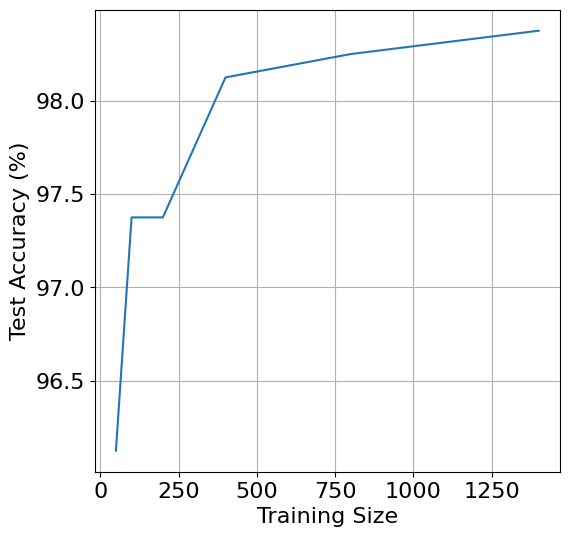

In [41]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.grid()
ax.plot(train_sizes, accuracy_list * 100)
ax.set_xlabel('Training Size')
ax.set_ylabel('Test Accuracy (%)')
fig.savefig('naive_bayes_spam.png', dpi=256)